In [3]:
%load_ext autoreload
%autoreload all

# TODO:
# how does it behave if only one valid input is given and the rest are generated inputs?
# Demonstrate what lack of training data looks like (len(tr_data) vs. error)
# bit error rate (SNR for analog)
# STDP

# Lorenz
# Noise in testing data and weights

import matplotlib.pyplot as plt
import numpy as np

from snn_dpe.tools.data import Mackey_Glass, util
from snn_dpe.tools.network import create_network, run_network_timeseries
from snn_dpe.tools.plotting import plot_network, plot_spike_raster
from snn_dpe.tools.train.timeseries import test_timeseries, train_TS

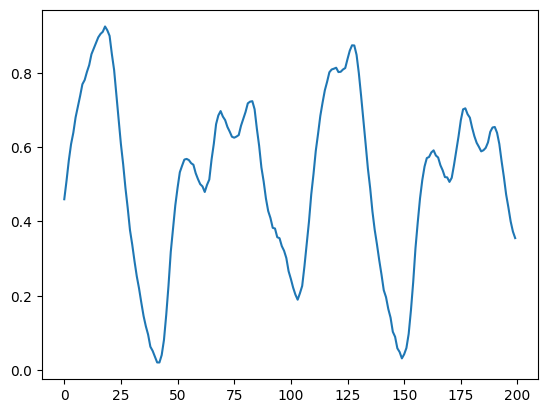

In [4]:
# read in training data and plot part of it
MG_data_tr = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/1.csv', normalize=True)
plot_len = 200
plt.plot(range(plot_len), MG_data_tr[:plot_len])

Number of Synapses: 90


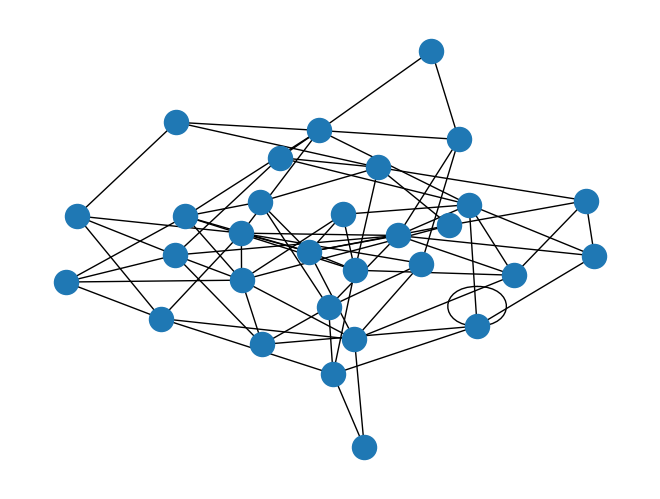

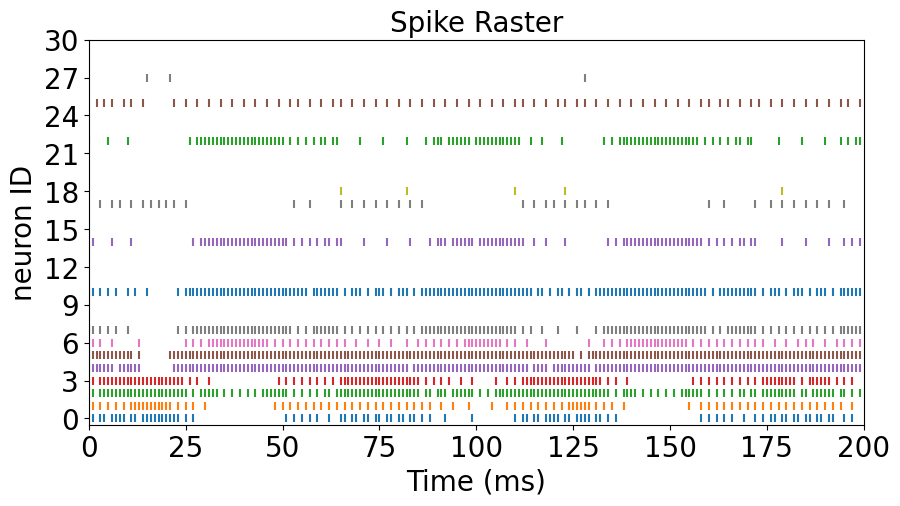

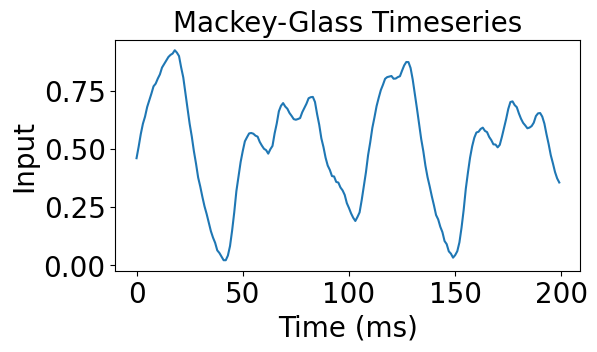

In [7]:
# create a test network
n_neurons = 30
synapse_density = 0.1
n_input = 6 #how many neurons will receive potentiation adjustments related to MG
n_synapses = int((n_neurons**2)*synapse_density)
print(f'Number of Synapses: {n_synapses}')

neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.1, 1), leak_range = (0.05, 0.15), weight_factor = 1)


spike_raster = run_network_timeseries(neurons, MG_data_tr[:plot_len], n_input)
plot_network(neurons)
plot_spike_raster(spike_raster)

# plot MG data
fig, ax = plt.subplots(figsize=(6,3))
# ax.set_xlim(0, plot_len)
ax.plot(range(plot_len), MG_data_tr[:plot_len])
ax.tick_params(axis='both', labelsize=20)
ax.set_ylabel('Input', fontsize=20)
ax.set_title('Mackey-Glass Timeseries', fontsize=20)
ax.set_xlabel('Time (ms)', fontsize=20)
plt.show()

In [8]:
# create a test network
n_neurons = 50
synapse_density = 0.1
n_input = 12 #how many neurons will receive potentiation adjustments related to MG
n_synapses = int((n_neurons**2)*synapse_density)

neurons = create_network(n_neurons, n_synapses, negative_weights = True, threshold_range = (0.35, 1), leak_range = (0.05, 0.25), weight_factor = 1)

# slice up MG into input, output pairs
input_window_size = 10
output_window_size = 1

# max here is 10,000 since that's the length of the csv
n_tr_data = 2000
n_te_data = 2000

MG_data_tr = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/1.csv', normalize=True)
MG_inputs_tr, MG_outputs_tr = util.generate_io_pairs(MG_data_tr[:n_tr_data], input_window_size, output_window_size)

# read data testing
MG_data_te = Mackey_Glass.read_MG_data('../../Data/MarkusThill-MGAB-60f6b17/3.csv', normalize=True)
MG_inputs_te, MG_outputs_te = util.generate_io_pairs(MG_data_te[:n_te_data], input_window_size, output_window_size)

n_epochs = 3
training_mses, testing_mses, relative_dpe_weights, dpe_bias_relative = train_TS(n_epochs, MG_inputs_tr, MG_outputs_tr, neurons, n_input, silent=False, TS_inputs_te=MG_inputs_te, TS_outputs_te=MG_outputs_te, relative=True)

Training MSE: 0.005122, Testing MSE: 0.006842: 100%|██████████| 1989/1989 [00:14<00:00, 140.99it/s]


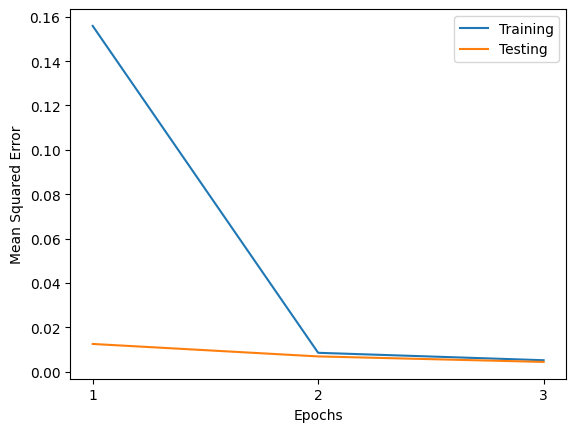

In [9]:
plt.plot(range(n_epochs), training_mses, label='Training')
plt.plot(range(n_epochs), testing_mses, label='Testing')
plt.ylabel('Mean Squared Error')
plt.xlabel('Epochs')
plt.xticks(range(n_epochs), labels = range(1, n_epochs+1))
plt.legend()
plt.show()

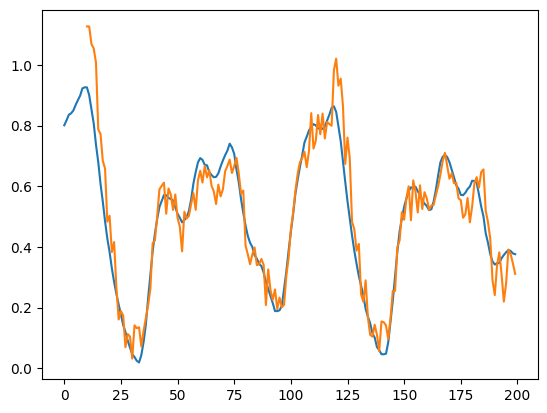

MSE over 1989 test samples: 0.00435834


In [10]:
test_mse = test_timeseries(MG_inputs_te, MG_outputs_te, neurons, relative_dpe_weights, n_input, TS_data=MG_data_te, bias = dpe_bias_relative, relative=True, plot_len=200)
print(f'MSE over {len(MG_inputs_te)} test samples: {test_mse:.8f}')